In [1]:
import numpy as np
from scipy.optimize import minimize
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class RobustOnlineHuberRegressor:
    def __init__(self, k=1.345, fit_intercept=True, reg_param=1e-4):
        self.k = k                           # Huber損失閾值
        self.fit_intercept = fit_intercept   # 正則化強度
        self.reg_param = reg_param           # 累積的設計矩陣
        self.A_total = None                  # 累積的目標向量
        self.b_total = None                  # 回歸係數
        self.coef_ = None                    # 截距項
        self.intercept_ = 0.0 if fit_intercept else None

    def _huber_loss(self, theta, X, y):
        residuals = y - X.dot(theta)
        loss = np.where(np.abs(residuals) <= self.k, 
                        0.5 * residuals**2,
                        self.k * np.abs(residuals) - 0.5 * self.k**2)
        return np.mean(loss)

    def predict(self, X):
        if self.fit_intercept:
            return X @ self.coef_ + self.intercept_
        else:
            return X @ self.coef_

    def fit_batch(self, X_batch, y_batch):
        # X_batch (array-like): 批次特徵矩陣
        # y_batch (array-like): 批次目標值
        # 如果需要截距項，添加全1列
        if self.fit_intercept:
            X_batch = np.column_stack([np.ones(len(X_batch)), X_batch])
        
        # 初始化累積矩陣
        if self.A_total is None:
            n_features = X_batch.shape[1]
            self.A_total = np.eye(n_features) * self.reg_param  # 初始化正則化項
            self.b_total = np.zeros(n_features)
        
        # 使用Least Squares Method作為初始解
        theta_init = np.linalg.lstsq(X_batch, y_batch, rcond=None)[0]
        
        # 使用L-BFGS-B優化Huber損失
        try:
            result = minimize(
                lambda theta: self._huber_loss(theta, X_batch, y_batch),
                theta_init,
                method='L-BFGS-B'
            )
            print("L-BFGS-B 收斂迭代次數:",result.nit)
            theta_t = result.x
        except:
            theta_t = theta_init  # 回退到Least Squares Method解

        A_t = X_batch.T @ X_batch
        self.A_total += A_t
        self.b_total += A_t @ theta_t

    def finalize(self):
        # 添加正則化項確保矩陣可逆
        self.A_total += np.eye(self.A_total.shape[0]) * self.reg_param
        self.coef_ = np.linalg.solve(self.A_total, self.b_total)
        
        if self.fit_intercept:
            self.intercept_ = self.coef_[0]
            self.coef_ = self.coef_[1:]
        return self

In [3]:
df=pd.read_csv("dataset/playground-series-s5e4/train.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


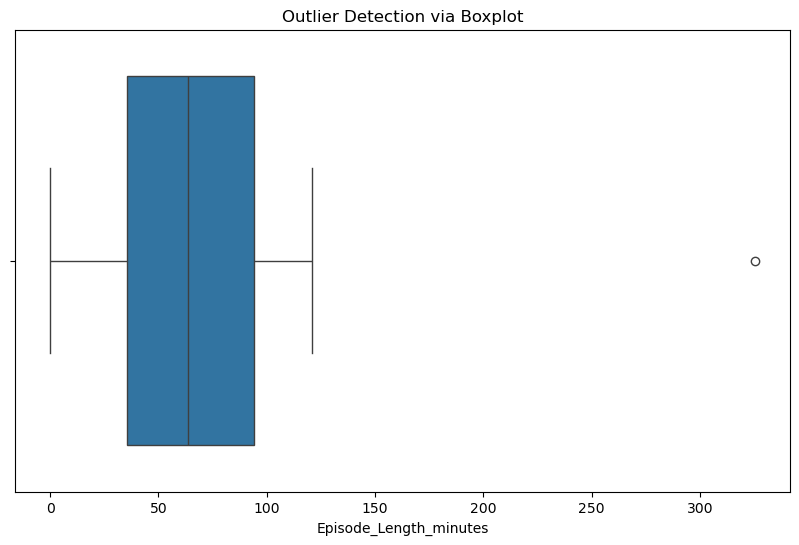

            id   Podcast_Name Episode_Title  Episode_Length_minutes  \
101637  101637  Home & Living    Episode 16                  325.24   

            Genre  Host_Popularity_percentage Publication_Day  \
101637  Lifestyle                       50.69         Tuesday   

       Publication_Time  Guest_Popularity_percentage  Number_of_Ads  \
101637        Afternoon                        15.01            0.0   

       Episode_Sentiment  Listening_Time_minutes  
101637          Positive                64.31981  


In [4]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["Episode_Length_minutes"])
plt.title("Outlier Detection via Boxplot")
plt.show()
print(df[df["Episode_Length_minutes"] > 300])

# 初步篩選資料

In [5]:
df=df.drop(101637,axis=0)
df.describe()
df["Episode_Length_minutes"].describe()

df["Episode_Length_minutes"]=df["Episode_Length_minutes"].fillna(df["Episode_Length_minutes"].mean())

df["Guest_Popularity_percentage"]=df["Guest_Popularity_percentage"].fillna(df["Guest_Popularity_percentage"].mean())

df["Number_of_Ads"].value_counts()
counts = df["Number_of_Ads"].value_counts()

remove = counts[(counts == 1) | (counts == 2)].index

df = df[~df["Number_of_Ads"].isin(remove)]
df["Number_of_Ads"].value_counts()

df["Number_of_Ads"]=df["Number_of_Ads"].fillna(df["Number_of_Ads"].median())

L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 7
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 7
L-BFGS-B 收斂迭代次數: 5
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 5
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 5
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 5
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 7
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 4
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 7
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 5
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭代次數: 6
L-BFGS-B 收斂迭

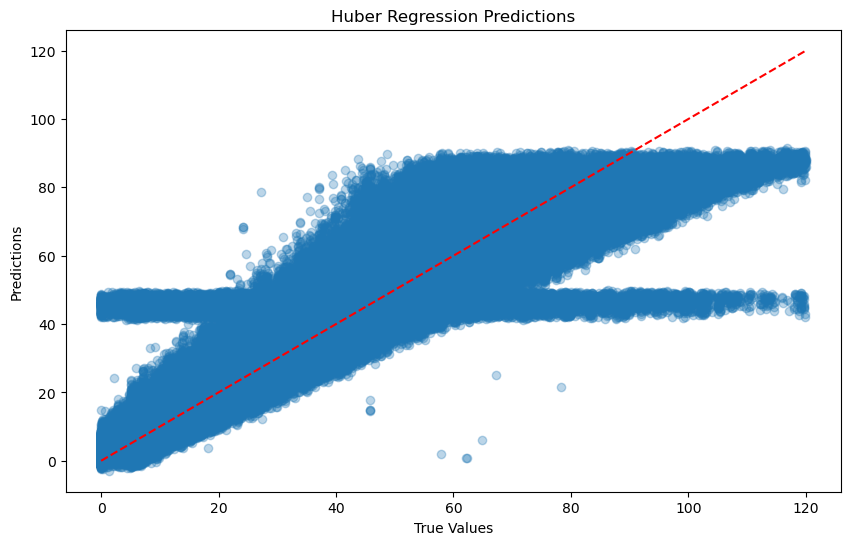

In [6]:
from sklearn.preprocessing import LabelEncoder
def preprocess_data(df):
    categories = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
    for col in categories:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df

df=preprocess_data(df)

X = df.drop(columns=['Listening_Time_minutes', 'id', 'Episode_Title',"Podcast_Name"])
y = df['Listening_Time_minutes']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 分割訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 安全標準化（添加缺失值檢查）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 確保無NaN/inf
assert not np.any(np.isnan(X_train_scaled)), "訓練集仍含NaN"
assert not np.any(np.isinf(X_train_scaled)), "訓練集含Inf"

# 初始化魯棒回歸器
huber_model = RobustOnlineHuberRegressor(
    k=1.345,          # Huber損失閾值
    fit_intercept=True, 
    reg_param=1e-4     # 正則化強度
)

start_time = time.time()

# 分批訓練
batch_size = 10000
compute_time = 0
for i in range(0, len(X_train_scaled), batch_size):
    X_batch = X_train_scaled[i:i+batch_size]
    y_batch = y_train.iloc[i:i+batch_size].values  # 轉為numpy array
    
    compute_start = time.time()    
    huber_model.fit_batch(X_batch, y_batch)
    compute_time += time.time() - compute_start

# 計算最終係數
huber_model.finalize()

print(f"訓練完成統計：")
print(f"計算時間: {compute_time:.2f}秒")

from sklearn.metrics import mean_absolute_error, mean_squared_error

# 驗證集預測
y_val_pred = huber_model.predict(X_val_scaled)

# 計算指標
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.2f}")
print("RMSE:" + str(mean_squared_error(y_val, y_val_pred)**0.5))

# 可視化預測 vs 真實值
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Huber Regression Predictions")
plt.show()